# DC Capital Bikeshare demand forecast
*How would weather and day affect bikeshare demand?*

* [UCI dataset (2011-2012)](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset)
* [About Capital Bikeshare, summary stats](https://www.capitalbikeshare.com/press-kit)

# Outline

* [Read Data](#read)
* [Data Summary](#data check)
* [Exploratory Data Analysis](#eda)
* [Feature Creation and Preprocessing](#preprocess)
* [Split data into test and train](#split)
* [Model and Score](#model) 
* [Predicition](#predict)
* [Reference](#reference)

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats
import pickle

### <a id="read">Read Data</a>

In [3]:
def readin(datafolder,filename):
    """
    read in files into pd df
    """
    inpath = datafolder
    infilename = filename
    infile = pd.read_csv(inpath + "/" +infilename)
    return infile

#datafolder = "data"
#hour = pd.read_csv(datafolder+"/hour.csv")
hour = readin("data", "hour.csv")
hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,dayofmonth,train
0,1,1/1/11,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1,1
1,2,1/1/11,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1,1
2,3,1/1/11,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,1,1
3,4,1/1/11,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,1,1
4,5,1/1/11,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,1,1


In [6]:
print("hours:",hour.columns)

hours: Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'dayofmonth', 'train'],
      dtype='object')


In [7]:
hour.shape #use hour data because more rows available

(17379, 19)

In [8]:
hour["yr"].value_counts()

1    8734
0    8645
Name: yr, dtype: int64

In [9]:
sum(hour["casual"])/sum(hour["cnt"])
sum(hour["registered"])/sum(hour["cnt"])

0.81169831617354748

In [10]:
hour.head(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,dayofmonth,train
0,1,1/1/11,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,1,1
1,2,1/1/11,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,1,1


### <a id="data check">Data Summary</a>

### Variables:
    - instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

### Data check:
1. coerce datatypes of "season, holiday, workingday, and weather" to be category
2. no missing values

In [11]:
hour.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dayofmonth      int64
train           int64
dtype: object

In [12]:
categoryVariableList = ["hr","weekday","mnth","season","weathersit","holiday","workingday"]
for var in categoryVariableList:
    hour[var] = hour[var].astype("category")

In [13]:
hour.isnull().values.any() #no missing values

False

In [14]:
hour.describe()

,instant,yr,temp,atemp,hum,windspeed,casual,registered,cnt,dayofmonth,train
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,0.502561,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088,15.683411,0.626388
std,5017.0295,0.500008,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599,8.789373,0.483776
min,1.0000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,4345.5000,0.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000,8.000000,0.000000
50%,8690.0000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000,16.000000,1.000000
75%,13034.5000,1.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000,23.000000,1.000000
max,17379.0000,1.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000,31.000000,1.000000


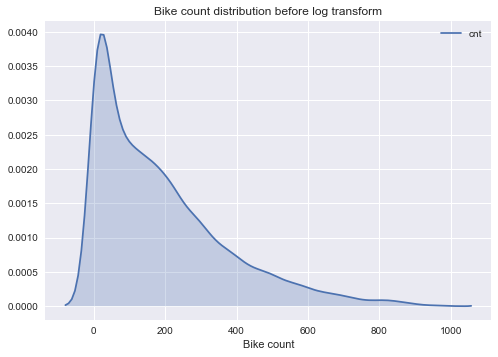

In [15]:
#check the distribution of count (response variable)
#fig,axes = plt.subplots(ncols=2,nrows=1)
#fig.set_size_inches(12, 10)

sn.kdeplot(hour["cnt"], shade = True)
sn.set_style("white")
sn.despine(left = True, bottom=True)
plt.xlabel('Bike count')
plt.title("Bike count distribution before log transform")
#stats.probplot(hour["cnt"], dist='norm', fit=True)

plt.show() #right skewed, not surprised given its a count variable, apply log transform later and investigate on the cnt = 1

In [16]:
lowcnt = hour[hour["cnt"] < 5]
lowcnt.shape
lowcnt["mnth"].value_counts() #month 1,2,3 and 12 have low demands

1     147
2     131
3     124
12     92
4      73
11     58
5      49
10     37
9      30
6      28
8      26
7      26
Name: mnth, dtype: int64

### <a id="eda">Exploratory Data Analysis</a>

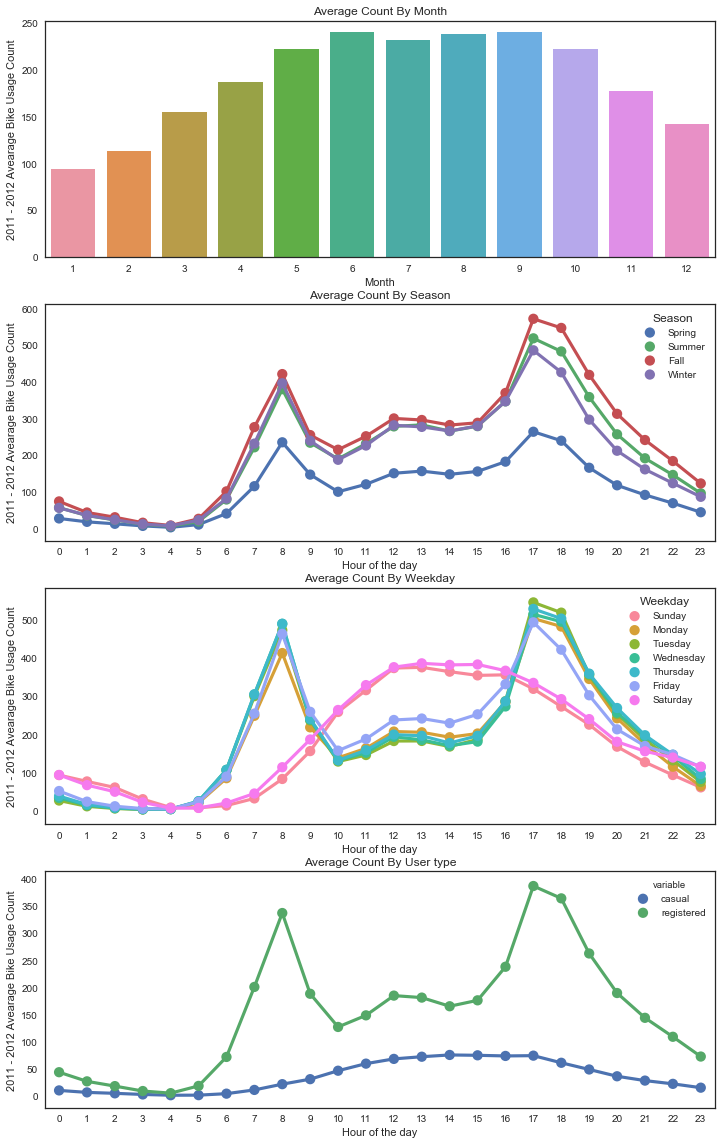

In [17]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)

monthAggregated = pd.DataFrame(hour.groupby("mnth")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="cnt",ascending=False)
sn.barplot(data=monthSorted,x="mnth",y="cnt", ax=ax1)
ax1.set(xlabel='Month', ylabel='2011 - 2012 Avearage Bike Usage Count',title="Average Count By Month")

sAggregated = pd.DataFrame(hour.groupby(["hr", "season"])["cnt"].mean()).reset_index()
sn.pointplot(x=sAggregated["hr"], y=sAggregated["cnt"],hue=sAggregated["season"], data=sAggregated, join=True,ax=ax2)
leg_handles = ax2.get_legend_handles_labels()[0]
ax2.legend(leg_handles, ["Spring","Summer","Fall","Winter"], title='Season')
ax2.set(xlabel='Hour of the day', ylabel='2011 - 2012 Avearage Bike Usage Count',title="Average Count By Season")

#People rent bikes in the morning and evening to commute during weekdays, and rent bikes for daytime rides on weekends
wkdAgg = pd.DataFrame(hour.groupby(["hr", "weekday"])["cnt"].mean()).reset_index()
sn.pointplot(x=wkdAgg["hr"], y=wkdAgg["cnt"],hue=wkdAgg["weekday"], data=wkdAgg, join=True,ax=ax3)
leg_handles = ax3.get_legend_handles_labels()[0]
ax3.legend(leg_handles, ["Sunday","Monday","Tuesday","Wednesday", "Thursday", "Friday", "Saturday"], title='Weekday')
ax3.set(xlabel='Hour of the day', ylabel='2011 - 2012 Avearage Bike Usage Count',title="Average Count By Weekday")

#Registerered users versus casual users bike behaviors - more casual users rent it during day times
hourTransformed = pd.melt(hour[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered'])
hourAgg = pd.DataFrame(hourTransformed.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
sn.pointplot(x=hourAgg["hr"], y=hourAgg["value"], hue=hourAgg["variable"], data=hourAgg, join=True, ax=ax4)
ax4.set(xlabel='Hour of the day', ylabel='2011 - 2012 Avearage Bike Usage Count',title="Average Count By User type")

plt.show()

**Correlation analysis**
* correlation plot between "count" and ["temp","atemp","hum","windspeed"].
* Observations:
    - atemp and temp are highly correlated, only keep 1 for model building
    - humidity negatively impacts demand
    - windspeed slightly impact demand

In [18]:
corrmat = hour[["temp", "atemp", "yr","hum", "windspeed", "dayofmonth","cnt"]].corr()
corrmat

,temp,atemp,yr,hum,windspeed,dayofmonth,cnt
temp,1.000000,0.987672,0.040913,-0.069881,-0.023125,0.027180,0.404772
atemp,0.987672,1.000000,0.039222,-0.051918,-0.062336,0.021269,0.400929
yr,0.040913,0.039222,1.000000,-0.083546,-0.008740,0.002057,0.250495
hum,-0.069881,-0.051918,-0.083546,1.000000,-0.290105,0.025663,-0.322911
windspeed,-0.023125,-0.062336,-0.008740,-0.290105,1.000000,0.010505,0.093234
dayofmonth,0.027180,0.021269,0.002057,0.025663,0.010505,1.000000,-0.004312
cnt,0.404772,0.400929,0.250495,-0.322911,0.093234,-0.004312,1.000000


**Outliers check**
* There appears to be outliers during workingday (remove later before model building)

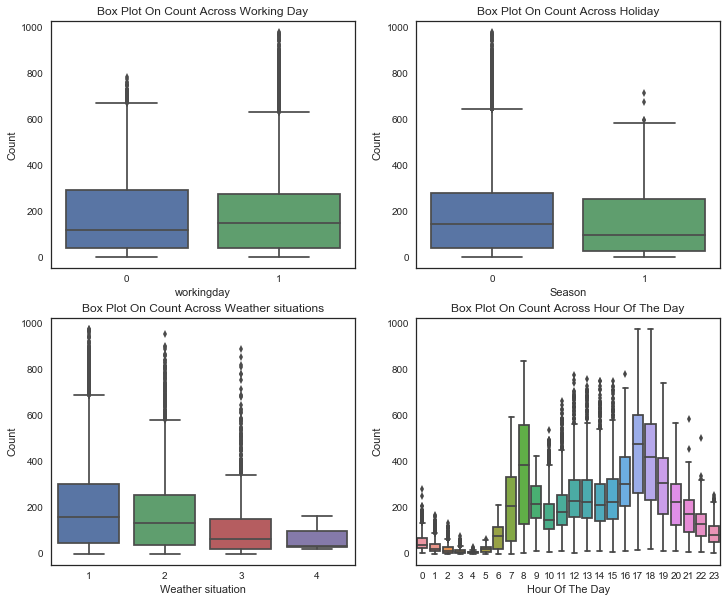

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=hour, y="cnt", x="workingday", orient="v", ax=axes[0][0]) #more outliers during workingday
sn.boxplot(data=hour, y="cnt", x="holiday", orient="v", ax=axes[0][1]) #more outliers during non-holiday
sn.boxplot(data=hour, y="cnt", x="weathersit", orient="v", ax=axes[1][0])
sn.boxplot(data=hour, y="cnt", x="hr", orient="v", ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count Across Working Day")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Holiday")
axes[1][0].set(xlabel='Weather situation', ylabel='Count',title="Box Plot On Count Across Weather situations")
axes[1][1].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
plt.show()

### <a id="preprocess">Feature Creation and Preprocessing</a>

In [20]:
hour.columns
#drop instant (row identifier)
hour = hour.drop(['instant'],axis=1)

#coerce feature types
hour.columns
dropFeatures = ["casual","atemp", "season","registered", "dteday", "dayofmonth", "workingday", "yr", "holiday"] 
#workingday not significant

### <a id="split">Split data into test and train</a>
* The training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. *

In [21]:
alldata = hour
#Drop unimportant features
alldata = hour.drop(dropFeatures, axis=1)

#check variable types
alldata.dtypes

mnth          category
hr            category
weekday       category
weathersit    category
temp           float64
hum            float64
windspeed      float64
cnt              int64
train            int64
dtype: object

In [4]:
#split into test and train
datatrain = alldata[alldata["train"]==1]
datatest = alldata[alldata["train"]!=1]

print(datatrain.shape)
print(datatest.shape)

NameError: name 'alldata' is not defined

### <a id="model">Model and Score</a>

**RMSLE Scorer **

<img src="score.png">

In [23]:
def rmsle(yhat,y,convertExp=True):
    if convertExp:
        y=np.exp(y),
        yhat=np.exp(yhat)
    log1 = np.nan_to_num(np.array([np.log(v+1) for v in yhat]))
    log2 = np.nan_to_num(np.array([np.log(v+1) for v in y]))
    diff = (log1-log2)**2
    return np.sqrt(np.mean(diff))

** Linear Regression Model **

In [24]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics, datasets
from scipy import stats
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [25]:
# Initialize linear regression model
lm = LinearRegression()

# logtransform y (count) 
yLabels = datatrain["cnt"]
yLabelsLog = np.log1p(yLabels)

X=datatrain.drop(["cnt", "train"], 1)
X.head()

,mnth,hr,weekday,weathersit,temp,hum,windspeed
0,1,0,6,1,0.24,0.81,0.0
1,1,1,6,1,0.22,0.80,0.0
2,1,2,6,1,0.22,0.80,0.0
3,1,3,6,1,0.24,0.75,0.0
4,1,4,6,1,0.24,0.75,0.0


In [26]:
# lm fit
lm.fit(X,y = yLabelsLog)
#params = np.append(lm.intercept_, lm.coef_)

# Make predictions
predictions = lm.predict(X)
print ("RMSLE Value For Linear Regression training data: ",rmsle(np.exp(yLabelsLog),np.exp(predictions),False))

RMSLE Value For Linear Regression training data:  1.00156452377


In [27]:
yLabelsLog.head()

0    2.833213
1    3.713572
2    3.496508
3    2.639057
4    0.693147
Name: cnt, dtype: float64

In [28]:
#Make prediction on test data
yLabelsLog = np.log1p(datatest["cnt"])

# Make predictions
X2=datatest.drop(["cnt", "train"], 1)
X2.head()
predstest = lm.predict(X2)
print ("RMSLE Value For Linear Regression using test data: ",rmsle(np.exp(yLabelsLog),np.exp(predstest),False))

RMSLE Value For Linear Regression using test data:  1.01861553796


In [29]:
lm.coef_

array([  5.99032165e-02,   9.73352175e-02,   1.67934051e-02,
         6.80365768e-04,   1.92326390e+00,  -1.54005915e+00,
         1.54498187e-01])

LM model updates since last time: I realized that my model's RMSLE score was low last week because I included count variable and highly correlated with the prediction variable. After removing the variable, the RMSLE increased and worsened. I also realized that in order to use the categorical variable that aren't binary properly, I would need to create dummy variables for season, weathersituation, etc. 

Because of the above, I would like to try random forest and gbm.

** Random Forest **

In [30]:
from sklearn.ensemble import RandomForestRegressor
rfModel = RandomForestRegressor(n_estimators=100)
yLabelsLog = np.log1p(yLabels)
rfModel.fit(X,yLabelsLog)
preds = rfModel.predict(X= X)
print ("RMSLE Value For Random Forest training: ",rmsle(np.exp(yLabelsLog),np.exp(preds),False))

RMSLE Value For Random Forest training:  0.137696052103


In [31]:
X.head()

,mnth,hr,weekday,weathersit,temp,hum,windspeed
0,1,0,6,1,0.24,0.81,0.0
1,1,1,6,1,0.22,0.80,0.0
2,1,2,6,1,0.22,0.80,0.0
3,1,3,6,1,0.24,0.75,0.0
4,1,4,6,1,0.24,0.75,0.0


In [32]:
#check feature importance
importance = rfModel.feature_importances_
importance = pd.DataFrame(importance, index=X.columns, columns=["Importance"])
importance

,Importance
mnth,0.045094
hr,0.735743
weekday,0.086920
weathersit,0.013008
temp,0.067636
hum,0.033360
windspeed,0.018238


In [44]:
yLabelsLog = np.log1p(datatest["cnt"])
rfpreds = rfModel.predict(X=X2)
print ("RMSLE Value For Random Forest test data: ",rmsle(np.exp(yLabelsLog),np.exp(rfpreds),False))

RMSLE Value For Random Forest test data:  0.493506612695


In [34]:
X2.head()

,mnth,hr,weekday,weathersit,temp,hum,windspeed
431,1,0,4,1,0.26,0.56,0.3881
432,1,1,4,1,0.26,0.56,0.0000
433,1,2,4,1,0.26,0.56,0.0000
434,1,3,4,1,0.26,0.56,0.1642
435,1,4,4,1,0.26,0.56,0.1642


In [35]:
#test rfModel on vector of user inputs
testdf = pd.DataFrame(np.array([[1,2,3,1,0.3,0.6,0.12]]), 
                      columns=["mnth", "hr", "weekday", "weathersit", "temp", "hum","windspeed"])

In [40]:
modelpred = rfModel.predict(X=testdf)
occupancy = np.exp(modelpred)/980*100 #max count in a day is 977
occupancy[0]

0.56368128176295929

In [48]:
rf_occupancy = np.exp(rfpreds)/980*100
rf_occupancy

array([  1.5230038 ,   0.606819  ,   0.58059692, ...,  14.53261566,
        10.3903612 ,   5.86830354])

In [49]:
rf_occupancy
print("mean",sum(rf_occupancy)/len(rf_occupancy))
import statistics
print("median", statistics.median(rf_occupancy))
max(rf_occupancy)

mean 18.3208248895
median 14.7074559115


86.926432696222776

In [ ]:
sn.boxplot(rf_occupancy)
plt.show()

In [ ]:
X2.head()
X.head()

In [ ]:
#Save model as a pickle file
model_name = "rf.pkl"
model_pkl = open(model_name, 'wb')
pickle.dump(rfModel, model_pkl)
model_pkl.close()

In [ ]:
X.dtypes